# openai gym intro
https://qiita.com/God_KonaBanana/items/c2cee09bc35cca722f2b

# DQN walker

In [109]:
import gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
import gym.spaces
import numpy as np

class drifters64():
    def __init__(self):
        
        self.L=-2
        self.counetr=0
        self.x1,self.y1=1,1
        self.vx1, self.vy1=0.5,1
        
        self.dt=1
        self.vmax=30
        #self.action_space=np.zeros((1,1))
        #self.action_space=np.zeros(2)
        self.action_space = gym.spaces.Discrete(3) # 行動空間。速度を下げる、そのまま、上げるの3種        
        
        self.img = cv2.imread("img//map64.bmp", 0).astype(np.float32)/255.0   
        self.img = self.img[:,:, np.newaxis]
        self.observation_space=self.img #np.zeros(4)
        #self.reward_range=np.zeros(2)
        #self.metadata =np.zeros(2)
        self.imgtmp = self.img.copy()        
        self.idx = 0        
        
        #self.codec = cv2.VideoWriter_fourcc(*'mp4v')
        #filepath   = '{:08}'.format(self.idx)+"_.mp4"
        #self.video = cv2.VideoWriter(filepath, self.codec, 10, (1000, 1000))
    
    def reset(self):
        self.L=-2
        self.counetr=0
        self.x1,self.y1=1,1
        self.vx,self.vy=0.5,1
        
        #self.obs1=np.array([self.x1,self.y1,self.vx,self.vy])
        self.img = cv2.imread("img//map64.bmp", 0).astype(np.float32)/255.0        
        self.img = self.img[:,:, np.newaxis]        
        self.imgtmp = self.img.copy()
        #cv2.circle(self.imgtmp,(1,1), 2, 0.5 ,thickness=2)        
        cv2.rectangle(self.imgtmp, (-1, -1), (3, 3), 0.5, thickness=-1)         
        
        self.obs1=self.imgtmp #np.zeros(4)

        #cv2.rectangle(img, (0, 0), (2, 2), 0.5, thickness=-1) 
        
        
        #if self.idx % 256 == 0:
        #    self.video.release()        
        #    filepath = '{:08}'.format(self.idx)+".mp4"
        #    self.video = cv2.VideoWriter(filepath, self.codec, 10, (1000, 1000))
        print(np.shape(self.obs1))                
        
        return self.obs1
    
    def step(self, action, monitor_frame=False):
        
        print(action)        
        action = action - 1
        
        #self.vx1 = self.vx1 + action[0] * self.dt
        self.vx1 = 0.5*self.vx1 + action * self.dt        
        #self.vx1 = action * self.dt                
        self.x1 = self.x1 + self.vx1 * self.dt
        
        self.vy1 = self.vy1 #+ action[1] * self.dt
        self.y1 = self.y1 + self.vy1 * self.dt
        
        self.counetr+=1
        #self.L+=self.dt        
            
        done=False            
        
        if self.x1 < 0 or self.y1 < 0 or self.x1 > 63  or self.img[max(0,min(63,int(self.y1))),max(0,min(63,int(self.x1)))]==0:
            self.L+=-10000
            done=True
            
        else:
            done=False

            if self.y1 > 60 and self.x1 > 60:            
                self.L+=1000
                done=True
            
            else:
                self.imgtmp = self.img.copy()            
                #cv2.circle(self.imgtmp,(int(self.x1),int(self.y1)), 2, 0.5 ,thickness=2)        
                cv2.rectangle(self.imgtmp, (int(self.x1)-2, int(self.y1)-2), (int(self.x1)+2, int(self.y1)+2), 0.5, thickness=-1)
                
                #self.L+=0.2*(1 + self.y1*0.01)              
                self.L+=0.1*(1 + self.y1*0.02 + self.x1*0.02)                              
            
        self.reward=self.L
        
        self.obs1=self.imgtmp #np.array([self.x1,self.y1,self.vx,self.vy])
        #print(np.shape(self.obs1))
        
        #if monitor_frame:
        if True:        

            imgtmp_bgr = cv2.cvtColor(self.imgtmp, cv2.COLOR_GRAY2BGR)
            cv2.rectangle(imgtmp_bgr, (int(self.x1)-2, int(self.y1)-2), (int(self.x1)+2, int(self.y1)+2), (0,0,1), thickness=-1)
                
            cv2.imwrite("video/" + '{:08}'.format(self.idx)+".jpg" , imgtmp_bgr*255)
            self.idx+=1
            
            
        #print("step")
        return self.obs1, self.reward, done, {}
    
    def render(self, mode='rgb_array'):
        
        print("monitor_frame test")
        self.imgtmp = self.img.copy()            
        #cv2.circle(self.imgtmp,(int(self.x1),int(self.y1)), 2, 0.5 ,thickness=2)        
        cv2.rectangle(self.imgtmp, (int(self.x1)-2, int(self.y1)-2), (int(self.x1)+2, int(self.y1)+2), 0.5, thickness=-1)
        
        cv2.imwrite("video/" + '{:08}'.format(self.idx)+".jpg" , self.imgtmp*255)
        self.idx+=1
                    
        #self.video.write(img_out)
                    
        return self.imgtmp

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate, Conv2D, Permute
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.policy import EpsGreedyQPolicy
import cv2
#env = drifters()#自作ゲームのプログラムを環境とする
env = drifters64()#自作ゲームのプログラムを環境とする

# save video 
#from gym import wrappers
#env = wrappers.Monitor(env, "C://code//gym//video", force=True)

print("env.action_space.shape")
print(env.action_space.shape)
#nb_actions = env.action_space.shape[0]
nb_actions = env.action_space.n
#nb_actions = env.action_space.n
#nb_actions = len(env.action_space.shape)
print("nb_actions: ", nb_actions)

model = Sequential()
#model.add(Input(input_shape=(1,) + env.observation_space.shape))
#model.add(Permute((2, 3, 1), input_shape=input_shape))
#model.add(Conv2D(32, (8, 8), strides=(4, 4), input_shape=(128, 128, 1)))

#model.add(Permute((2, 3, 1), input_shape=(1,) + env.observation_space.shape))
model.add(Conv2D(32, (8, 8), strides=(4, 4), input_shape=(2,) + env.observation_space.shape))
#model.add(Conv2D(32, (8, 8), strides=(4, 4)))
#model.add(Permute((2, 3, 1)))  # (window,w,h) -> (w,h,window)

#model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(16, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
#model.add(Activation('sigmoid'))
print(model.summary())

# experience replay用のmemory
memory = SequentialMemory(limit=50000, window_length=2)
# 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
policy = EpsGreedyQPolicy(eps=0.1) 
#policy = BoltzmannQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
#dqn.load_weights("dqn_model_weight_h5.h5")

history = dqn.fit(env, nb_steps=10000, visualize=False, verbose=2, nb_max_episode_steps=300)
#学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,
#dqn.test(env, nb_episodes=1, visualize=False, nb_max_episode_steps=300)




env.action_space.shape
()
nb_actions:  3
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 1, 15, 15, 32)     2080      
_________________________________________________________________
activation_328 (Activation)  (None, 1, 15, 15, 32)     0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 1, 6, 6, 16)       8208      
_________________________________________________________________
activation_329 (Activation)  (None, 1, 6, 6, 16)       0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 1, 4, 4, 16)       2320      
_________________________________________________________________
activation_330 (Activation)  (None, 1, 4, 4, 16)       0         
_________________________________________________________________
flatten_55 (

C:\Users\user\.conda\envs\py36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 8000 steps ...
(64, 64, 1)


C:\Users\user\.conda\envs\py36\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1
2
2
0
2
1
2
2
2
2
1
2


C:\Users\user\.conda\envs\py36\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


0
2
0
2
2
2
2
2
2
2
2
   23/8000: episode: 1, duration: 20.858s, episode steps:  23, steps per second:   1, episode reward: -9305.560, mean reward: -404.590 [-9942.360, 63.579], mean action: 1.609 [0.000, 2.000],  loss: 223.583669, mae: 7.513526, mean_q: 8.678075
(64, 64, 1)
2
2


C:\Users\user\.conda\envs\py36\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


2
2
2
2
2
1
2
0
2
0
0
1
2
0
2
2
0
1
2
2
0
   46/8000: episode: 2, duration: 3.295s, episode steps:  23, steps per second:   7, episode reward: -9260.811, mean reward: -402.644 [-9940.500, 65.770], mean action: 1.348 [0.000, 2.000],  loss: 1951404.875000, mae: 140.111237, mean_q: 6.738910
(64, 64, 1)
2
0
2
2
2
0
1
1
0
0
2
1
1
1
0
1
1
0
   64/8000: episode: 3, duration: 2.535s, episode steps:  18, steps per second:   7, episode reward: -9623.497, mean reward: -534.639 [-9959.263, 40.737], mean action: 0.944 [0.000, 2.000],  loss: 1802168.500000, mae: 129.774963, mean_q: 0.077685
(64, 64, 1)
0
   65/8000: episode: 4, duration: 0.291s, episode steps:   1, steps per second:   3, episode reward: -10002.000, mean reward: -10002.000 [-10002.000, -10002.000], mean action: 0.000 [0.000, 0.000],  loss: 4638829.500000, mae: 319.917297, mean_q: 0.093280
(64, 64, 1)
2
0
0
   68/8000: episode: 5, duration: 0.533s, episode steps:   3, steps per second:   6, episode reward: -9995.347, mean reward: -333

1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
  783/8000: episode: 28, duration: 2.444s, episode steps:  17, steps per second:   7, episode reward: -9684.392, mean reward: -569.670 [-9963.791, 36.209], mean action: 0.941 [0.000, 1.000],  loss: 2210631.500000, mae: 1257.232178, mean_q: -439.322052
(64, 64, 1)
2
2
1
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
  818/8000: episode: 29, duration: 4.869s, episode steps:  35, steps per second:   7, episode reward: -8030.560, mean reward: -229.445 [-9875.200, 128.880], mean action: 1.914 [0.000, 2.000],  loss: 1718158.625000, mae: 1094.431641, mean_q: -430.034912
(64, 64, 1)
2
2
2
0
1
1
1
0
1
2
2
0
2
2
1
2
1
2
1
0
0
0
0
2
1
0
1
2
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
  890/8000: episode: 30, duration: 10.798s, episode steps:  72, steps per second:   7, episode reward: 21044.800, mean reward: 292.289 [ 0.200, 10629.560], mean action: 1.417 [0.000, 2.000],  loss: 1434940.875000, mae: 1181.054

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
1
2
0
2
2
1
0
0
1
0
1
2
0
2
2
0
0
2
1
2
2
1
0
2
2
 1644/8000: episode: 53, duration: 7.009s, episode steps:  50, steps per second:   7, episode reward: -6492.848, mean reward: -129.857 [-9850.305, 155.205], mean action: 1.120 [0.000, 2.000],  loss: 1831318.875000, mae: 863.490234, mean_q: -574.092529
(64, 64, 1)
1
2
0
1
0
1
2
0
1
1
2
2
2
0
2
1
0
2
0
2
0
1
0
0
0
1
 1670/8000: episode: 54, duration: 4.209s, episode steps:  26, steps per second:   6, episode reward: -9170.489, mean reward: -352.711 [-9934.899, 65.101], mean action: 0.923 [0.000, 2.000],  loss: 1060532.250000, mae: 835.515747, mean_q: -596.653992
(64, 64, 1)
2
1
0
2
0
2
0
2
2
2
2
1
2
2
1
1
0
2
0
1
2
0
0
2
2
1
2
1
1
0
2
1
2
2
 1704/8000: episode: 55, duration: 4.638s, episode steps:  34, steps per second:   7, episode reward: -8434.206, mean reward: -248.065 [-9907.160, 98.779], mean action: 1.265 [0.000, 2.000],  loss: 1472223.375000, mae: 836.729309, mean_q: -604.115051
(64, 6

0
0
2
2
1
0
0
0
1
 1883/8000: episode: 82, duration: 1.604s, episode steps:  11, steps per second:   7, episode reward: -9872.053, mean reward: -897.459 [-9978.465, 21.535], mean action: 0.818 [0.000, 2.000],  loss: 1691723.125000, mae: 849.305481, mean_q: -562.970276
(64, 64, 1)
0
 1884/8000: episode: 83, duration: 0.261s, episode steps:   1, steps per second:   4, episode reward: -10002.000, mean reward: -10002.000 [-10002.000, -10002.000], mean action: 0.000 [0.000, 0.000],  loss: 1397416.250000, mae: 861.449585, mean_q: -611.638916
(64, 64, 1)
2
2
0
0
1
1
 1890/8000: episode: 84, duration: 0.915s, episode steps:   6, steps per second:   7, episode reward: -9967.971, mean reward: -1661.329 [-9990.931,  9.069], mean action: 1.000 [0.000, 2.000],  loss: 2136270.750000, mae: 1006.146240, mean_q: -702.603699
(64, 64, 1)
1
0
 1892/8000: episode: 85, duration: 0.392s, episode steps:   2, steps per second:   5, episode reward: -9999.772, mean reward: -4999.886 [-9999.886,  0.114], mean act

In [ ]:
dqn.save_weights("dqn_model_weight_h5.h5") 

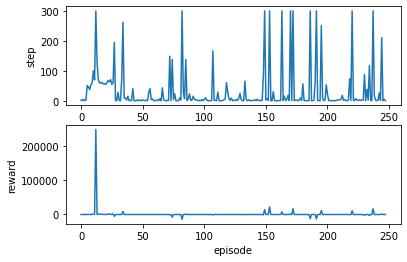

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

# 結果を表示
plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")

plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")

plt.show()  # windowが表示されます。